# transformation tests

its still unclear to me which modifications of midi files are able to be applied to the `PrettyMIDI` object vs. needing to be written out to the filesystem then read back in. This notebook tests that somewhat.


## imports


In [39]:
import os
from pathlib import Path
import mido
import pretty_midi
import numpy as np
from matplotlib import pyplot as plt
from mido import MidiFile
from pretty_midi import PrettyMIDI, Instrument, Note

from typing import Dict

plt.style.use("dark_background")

num_beats = 8

## functions


In [40]:
def plot_prs(pr, bpr, title, bpms) -> None:
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(2, 1, 1)
    plt.imshow(pr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"original")
    plt.xlabel("time (ms)")
    plt.ylabel("MIDI note number")
    beat_interval = 60 / bpms[0]  # seconds per beat
    beat = 0
    while beat * beat_interval * 100 < pr.shape[1]:
        plt.axvline(x=beat * beat_interval * 100, color="green", linestyle=":")
        beat += 1

    plt.subplot(2, 1, 2)
    plt.imshow(bpr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"shifted")
    plt.xlabel("")
    plt.ylabel("")
    beat_interval = 60.0 / bpms[1]  # seconds per beat
    beat = 0
    while beat * beat_interval * 100 < pr.shape[1]:
        plt.axvline(x=beat * beat_interval * 100, color="green", linestyle=":")
        beat += 1

    plt.tight_layout()
    plt.show()

In [41]:
def change_tempo(file_path: str, tempo: int):
    midi = mido.MidiFile(file_path)
    new_tempo = mido.bpm2tempo(tempo)
    new_message = mido.MetaMessage("set_tempo", tempo=new_tempo, time=0)
    tempo_added = False

    for track in midi.tracks:
        # remove existing set_tempo messages
        for msg in track:
            if msg.type == "set_tempo":
                track.remove(msg)

        # add new set_tempo message to the first track
        if not tempo_added:
            track.insert(0, new_message)
            tempo_added = True

    # if no tracks had a set_tempo message and no new one was added, add a new track with the tempo message
    if not tempo_added:
        new_track = mido.MidiTrack()
        new_track.append(new_message)
        midi.tracks.append(new_track)

    midi.save(file_path)

In [42]:
def transform(file_path: str, out_dir: str, tempo: int, transformations: Dict) -> str:
    new_filename = f"{Path(file_path).stem}_t{transformations["transpose"]:02d}s{transformations["shift"]:02d}.mid"
    out_path = os.path.join(out_dir, new_filename)
    MidiFile(file_path).save(out_path) # in case transpose is 0

    if transformations["transpose"] != 0:
        t_midi = PrettyMIDI(initial_tempo=tempo)

        for instrument in PrettyMIDI(out_path).instruments:
            transposed_instrument = Instrument(program=instrument.program, name=new_filename[:-4])

            for note in instrument.notes:
                transposed_instrument.notes.append(
                    Note(
                        velocity=note.velocity,
                        pitch=note.pitch + int(transformations["transpose"]),
                        start=note.start,
                        end=note.end,
                    )
                )

            t_midi.instruments.append(transposed_instrument)

        t_midi.write(out_path)

    if transformations["shift"] != 0:
        s_midi = PrettyMIDI(initial_tempo=tempo)
        seconds_per_beat = 60 / tempo
        shift_seconds = transformations["shift"] * seconds_per_beat
        loop_point = (num_beats + 1) * seconds_per_beat

        for instrument in PrettyMIDI(out_path).instruments:
            shifted_instrument = Instrument(
                program=instrument.program, name=new_filename[:-4]
            )
            for note in instrument.notes:
                dur = note.end - note.start
                shifted_start = (note.start + shift_seconds) % loop_point
                shifted_end = shifted_start + dur

                if note.start + shift_seconds >= loop_point:
                    shifted_start += seconds_per_beat
                    shifted_end += seconds_per_beat

                shifted_instrument.notes.append(
                    Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=shifted_start,
                        end=shifted_end
                    )
                )

            s_midi.instruments.append(shifted_instrument)

        s_midi.write(out_path)

    change_tempo(out_path, tempo)

    return out_path

In [43]:
def play_midi(file_path, output_port_name):
    mid = mido.MidiFile(file_path)

    with mido.open_output(output_port_name) as outport:  # type: ignore
        print(f"Playing {file_path} on {output_port_name}...")
        for msg in mid.play():
            if not msg.is_meta:
                outport.send(msg)

    print("Playback finished.")

## go


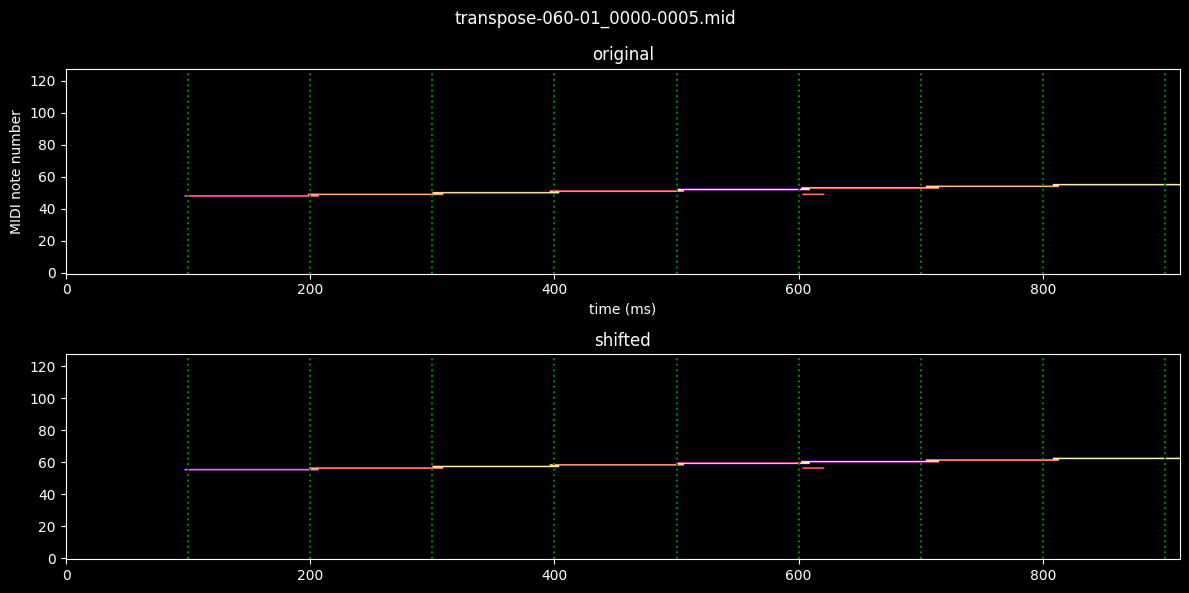

shifting notes by 1.0 s, e.g. 1.0 --> 2.0
loop point is 9.0
start:	0.977 -> 1.977
end:	2.073 -> 3.073
start:	1.991 -> 2.991
end:	3.095 -> 4.095
start:	3.000 -> 4.000
end:	4.041 -> 5.041
start:	3.968 -> 4.968
end:	5.064 -> 6.064
start:	5.000 -> 6.000
end:	6.095 -> 7.095
start:	6.032 -> 7.032
end:	6.218 -> 7.218
start:	6.023 -> 7.023
end:	7.155 -> 8.155
start:	7.041 -> 8.041
end:	8.136 -> 9.136
looping! adding 1.0
start:	8.082 -> 1.082
end:	9.136 -> 2.136


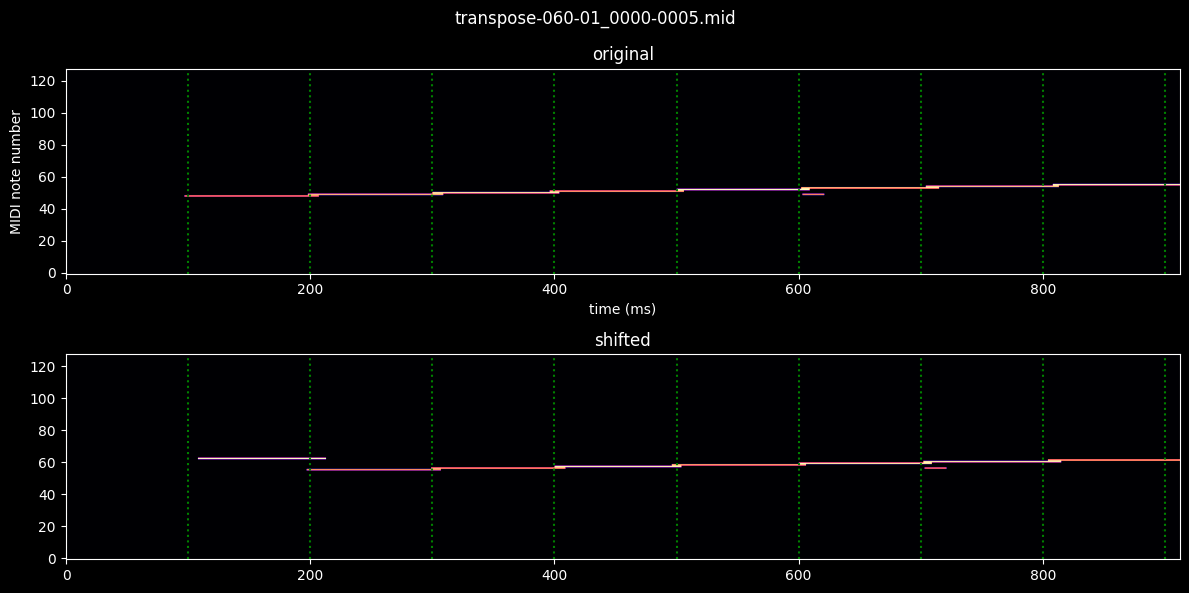

shifting notes by 2.0 s, e.g. 1.0 --> 3.0
loop point is 9.0
start:	0.977 -> 2.977
end:	2.073 -> 4.073
start:	1.991 -> 3.991
end:	3.095 -> 5.095
start:	3.000 -> 5.000
end:	4.041 -> 6.041
start:	3.968 -> 5.968
end:	5.064 -> 7.064
start:	5.000 -> 7.000
end:	6.095 -> 8.095
start:	6.032 -> 8.032
end:	6.218 -> 8.218
start:	6.023 -> 8.023
end:	7.155 -> 9.155
looping! adding 1.0
start:	7.041 -> 1.041
end:	8.136 -> 2.136
looping! adding 1.0
start:	8.082 -> 2.082
end:	9.136 -> 3.136


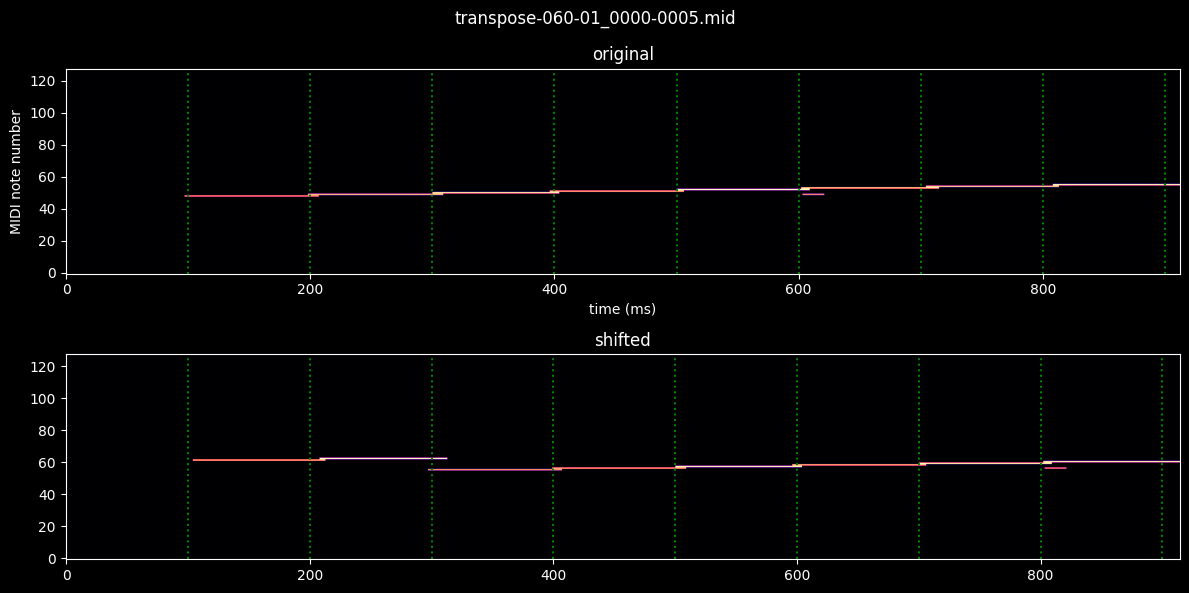

shifting notes by 3.0 s, e.g. 1.0 --> 4.0
loop point is 9.0
start:	0.977 -> 3.977
end:	2.073 -> 5.073
start:	1.991 -> 4.991
end:	3.095 -> 6.095
start:	3.000 -> 6.000
end:	4.041 -> 7.041
start:	3.968 -> 6.968
end:	5.064 -> 8.064
start:	5.000 -> 8.000
end:	6.095 -> 9.095
looping! adding 1.0
start:	6.032 -> 1.032
end:	6.218 -> 1.218
looping! adding 1.0
start:	6.023 -> 1.023
end:	7.155 -> 2.155
looping! adding 1.0
start:	7.041 -> 2.041
end:	8.136 -> 3.136
looping! adding 1.0
start:	8.082 -> 3.082
end:	9.136 -> 4.136


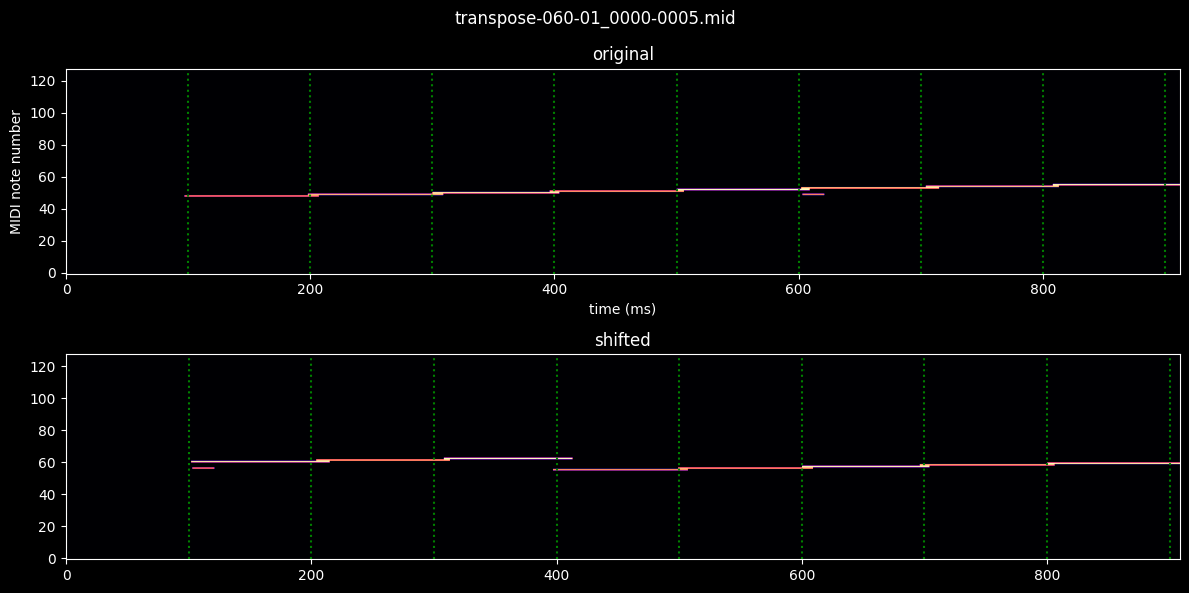

shifting notes by 4.0 s, e.g. 1.0 --> 5.0
loop point is 9.0
start:	0.977 -> 4.977
end:	2.073 -> 6.073
start:	1.991 -> 5.991
end:	3.095 -> 7.095
start:	3.000 -> 7.000
end:	4.041 -> 8.041
start:	3.968 -> 7.968
end:	5.064 -> 9.064
looping! adding 1.0
start:	5.000 -> 1.000
end:	6.095 -> 2.095
looping! adding 1.0
start:	6.032 -> 2.032
end:	6.218 -> 2.218
looping! adding 1.0
start:	6.023 -> 2.023
end:	7.155 -> 3.155
looping! adding 1.0
start:	7.041 -> 3.041
end:	8.136 -> 4.136
looping! adding 1.0
start:	8.082 -> 4.082
end:	9.136 -> 5.136


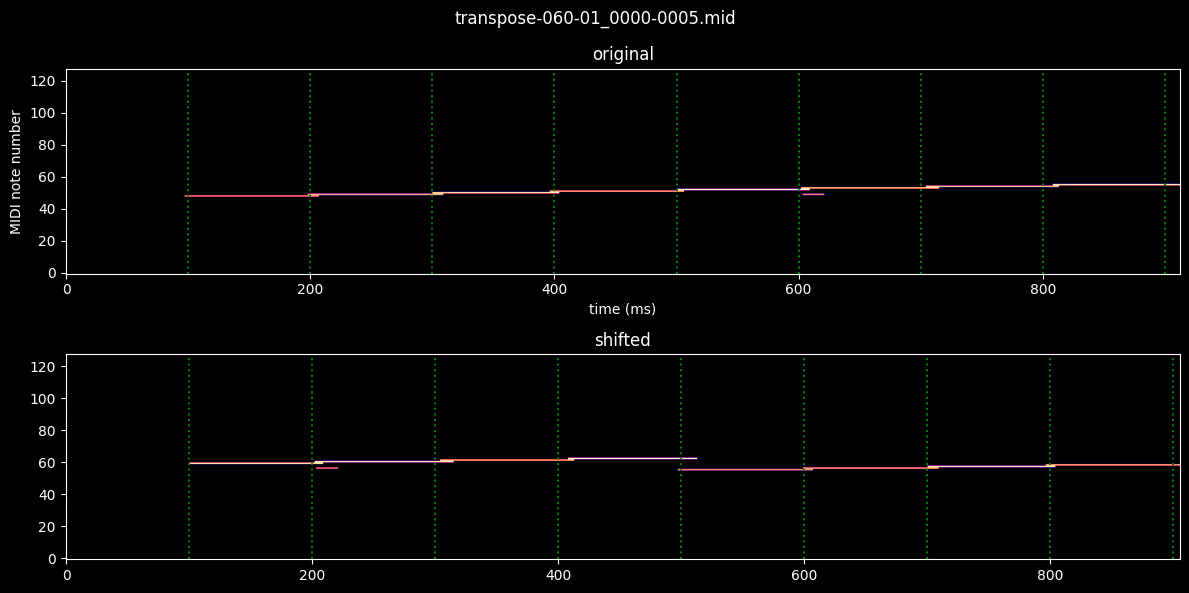

shifting notes by 5.0 s, e.g. 1.0 --> 6.0
loop point is 9.0
start:	0.977 -> 5.977
end:	2.073 -> 7.073
start:	1.991 -> 6.991
end:	3.095 -> 8.095
start:	3.000 -> 8.000
end:	4.041 -> 9.041
start:	3.968 -> 8.968
end:	5.064 -> 10.064
looping! adding 1.0
start:	5.000 -> 2.000
end:	6.095 -> 3.095
looping! adding 1.0
start:	6.032 -> 3.032
end:	6.218 -> 3.218
looping! adding 1.0
start:	6.023 -> 3.023
end:	7.155 -> 4.155
looping! adding 1.0
start:	7.041 -> 4.041
end:	8.136 -> 5.136
looping! adding 1.0
start:	8.082 -> 5.082
end:	9.136 -> 6.136


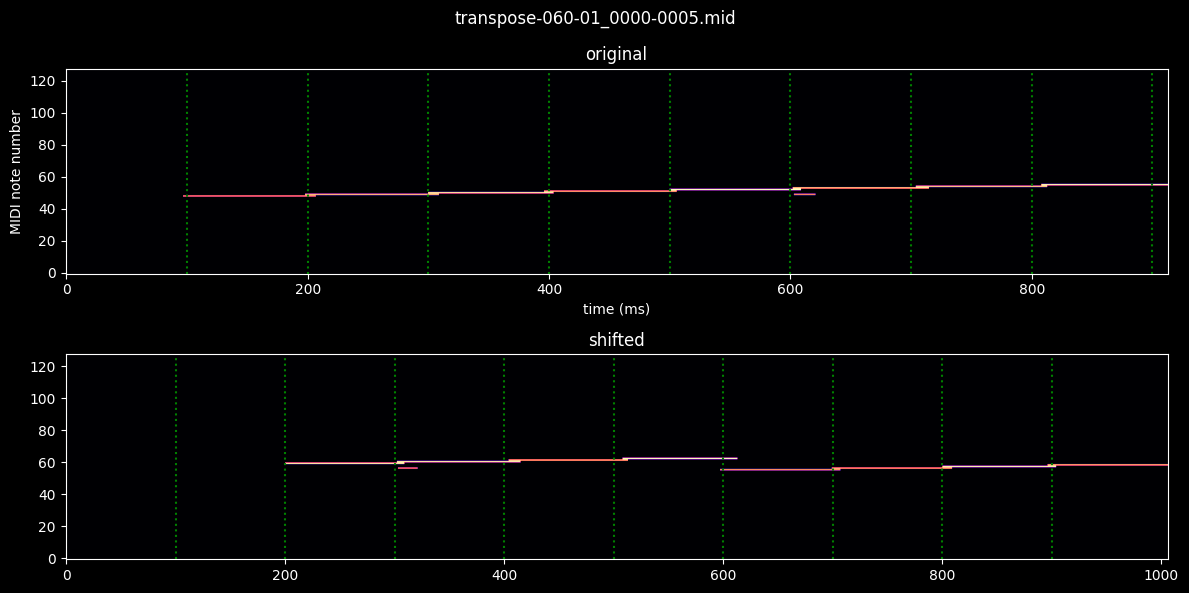

shifting notes by 6.0 s, e.g. 1.0 --> 7.0
loop point is 9.0
start:	0.977 -> 6.977
end:	2.073 -> 8.073
start:	1.991 -> 7.991
end:	3.095 -> 9.095
looping! adding 1.0
start:	3.000 -> 1.000
end:	4.041 -> 2.041
looping! adding 1.0
start:	3.968 -> 1.968
end:	5.064 -> 3.064
looping! adding 1.0
start:	5.000 -> 3.000
end:	6.095 -> 4.095
looping! adding 1.0
start:	6.032 -> 4.032
end:	6.218 -> 4.218
looping! adding 1.0
start:	6.023 -> 4.023
end:	7.155 -> 5.155
looping! adding 1.0
start:	7.041 -> 5.041
end:	8.136 -> 6.136
looping! adding 1.0
start:	8.082 -> 6.082
end:	9.136 -> 7.136


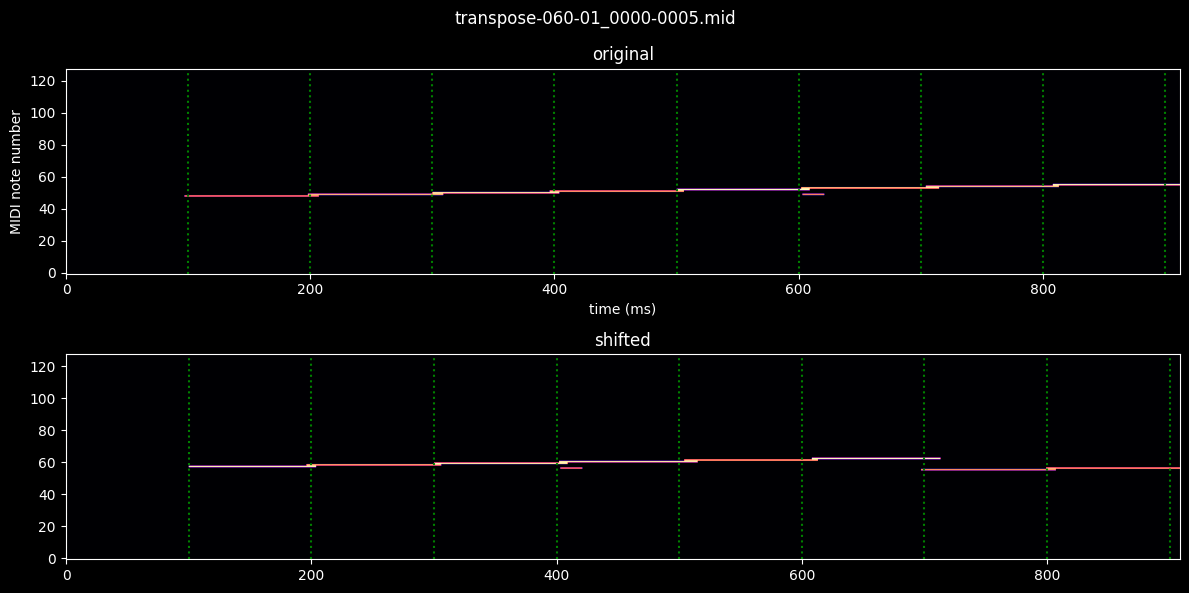

shifting notes by 7.0 s, e.g. 1.0 --> 8.0
loop point is 9.0
start:	0.977 -> 7.977
end:	2.073 -> 9.073
start:	1.991 -> 8.991
end:	3.095 -> 10.095
looping! adding 1.0
start:	3.000 -> 2.000
end:	4.041 -> 3.041
looping! adding 1.0
start:	3.968 -> 2.968
end:	5.064 -> 4.064
looping! adding 1.0
start:	5.000 -> 4.000
end:	6.095 -> 5.095
looping! adding 1.0
start:	6.032 -> 5.032
end:	6.218 -> 5.218
looping! adding 1.0
start:	6.023 -> 5.023
end:	7.155 -> 6.155
looping! adding 1.0
start:	7.041 -> 6.041
end:	8.136 -> 7.136
looping! adding 1.0
start:	8.082 -> 7.082
end:	9.136 -> 8.136


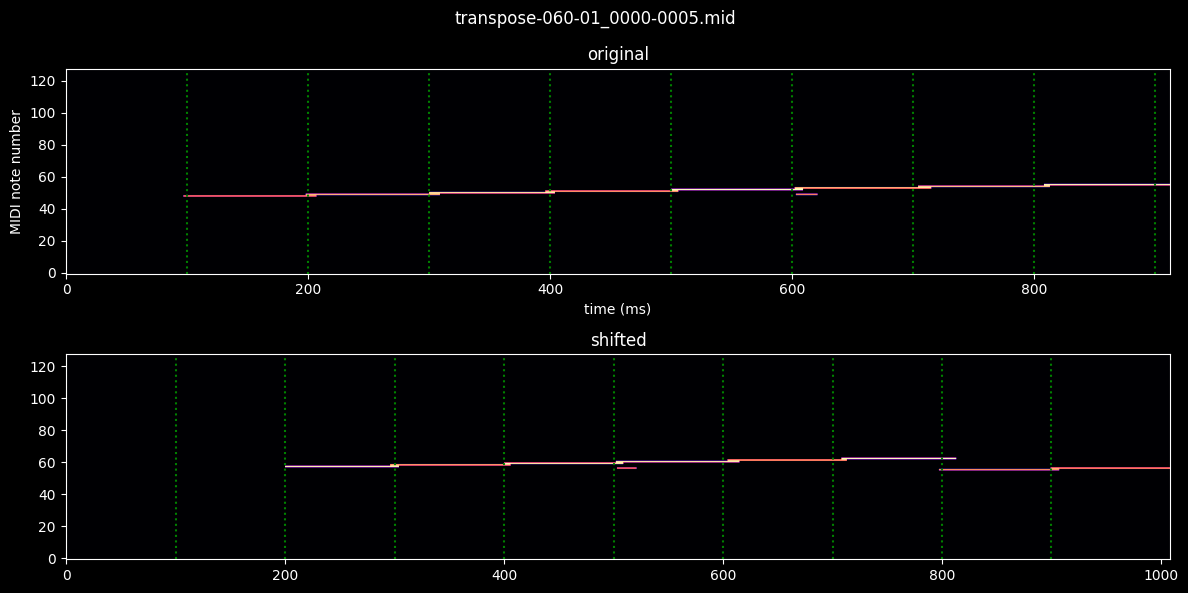

shifting notes by 8.0 s, e.g. 1.0 --> 0.0
loop point is 9.0
start:	0.977 -> 8.977
end:	2.073 -> 10.073
looping! adding 1.0
start:	1.991 -> 1.991
end:	3.095 -> 3.095
looping! adding 1.0
start:	3.000 -> 3.000
end:	4.041 -> 4.041
looping! adding 1.0
start:	3.968 -> 3.968
end:	5.064 -> 5.064
looping! adding 1.0
start:	5.000 -> 5.000
end:	6.095 -> 6.095
looping! adding 1.0
start:	6.032 -> 6.032
end:	6.218 -> 6.218
looping! adding 1.0
start:	6.023 -> 6.023
end:	7.155 -> 7.155
looping! adding 1.0
start:	7.041 -> 7.041
end:	8.136 -> 8.136
looping! adding 1.0
start:	8.082 -> 8.082
end:	9.136 -> 9.136


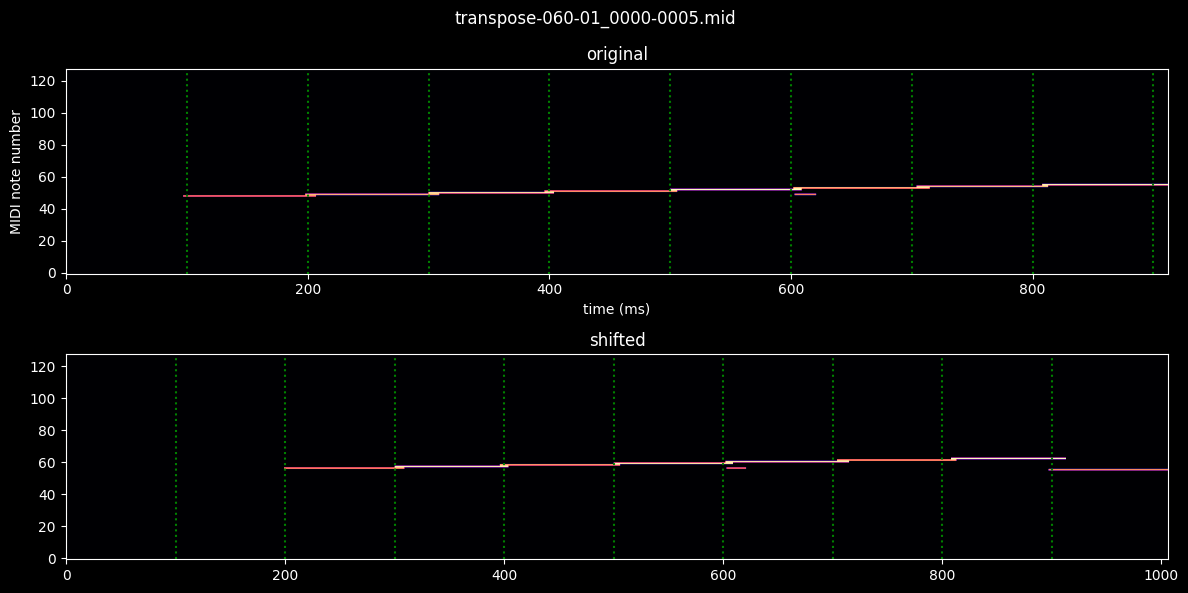

In [44]:
file = "files/transpose-060-01_0000-0005.mid"
tempo = 60
tempo_set_file = change_tempo(file, tempo)
og_pr = pretty_midi.PrettyMIDI(tempo_set_file).get_piano_roll()

for shift in range(9):
    transformations = {
        "tempo": tempo,
        "shift": shift,
        "transpose": 7,
    }

    new_file = transform(tempo_set_file, "files/out", tempo, transformations)
    new_pr = pretty_midi.PrettyMIDI(new_file).get_piano_roll()

    plot_prs(og_pr, new_pr, "transpose-060-01_0000-0005.mid", [tempo, tempo])